In [81]:
from base64 import b64encode

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from qutip import (about, basis, coherent, destroy, displace, expect, mesolve,
                   num, plot_fock_distribution, plot_wigner, squeeze, variance, tensor, qeye)

%matplotlib inline

In [215]:
pi = np.pi

input_power_dBm = -150
power = 1e-3 * 10 ** (input_power_dBm/10)
hbar = 6.62e-34/(2*pi)
w_a = 4.0e9*2*pi # just for the nbar calculation (bc solved in rotating frame)
kappa = 1e6 * 2  *pi

amplR = np.sqrt(power / (hbar*w_a))

steady_state_nbar = 4*amplR**2/kappa

w_1 = 0e6 * 2 * pi

print(steady_state_nbar)

n_th_a = 0.0

phi_1 = 0
N = 30
alpha = -0.01e6*2*np.pi

a = destroy(N)
n = num(N)
x = (a + a.dag()) / np.sqrt(2)
p = -1j * (a - a.dag()) / np.sqrt(2)

tlist = np.arange(0, np.round(20/kappa,9), 1e-9)

t0 = 1e-8
tau = 1e-8

P = 8*np.pi/2

# eps_1 = P/tau/np.sqrt(np.pi/6)*np.exp(-6*((tlist-t0)/tau)**2)*1j  # envelope
# eps_1 = 5.5e7j
eps_1 = 1j*np.sqrt(kappa)*amplR

H0 = alpha*(a.dag()*a.dag()*a*a) # dynamics are solved in the rotating frame

H1_1 = a.dag()

H1_2 = a

#blais 2021 convention
H = [[H0, tlist*0 + 1],[H1_1,eps_1*np.exp(-1j*w_1*tlist - 1j*phi_1)],[H1_2,np.conj(eps_1)*np.exp(1j*w_1*tlist + 1j*phi_1)]]

H0.eigenenergies()/(2*np.pi)

c_op_list = []

rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)

rate = kappa * n_th_a
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())


0.24041532189108059


In [216]:
def plot_expect_with_variance(N, op_list, op_title, states):
    """
    Plot the expectation value of an operator (list of operators)
    with an envelope that describes the operators variance.
    """

    fig, axes = plt.subplots(1, len(op_list), figsize=(14, 3))

    for idx, op in enumerate(op_list):

        e_op = expect(op, states)
        v_op = variance(op, states)

        axes[idx].fill_between(
            tlist, e_op - np.sqrt(v_op), e_op + np.sqrt(v_op), color="green",
            alpha=0.5)
        axes[idx].plot(tlist, e_op, label="expectation")
        axes[idx].set_xlabel("Time")
        axes[idx].set_title(op_title[idx])
        
    plt.show()

    return fig, axes

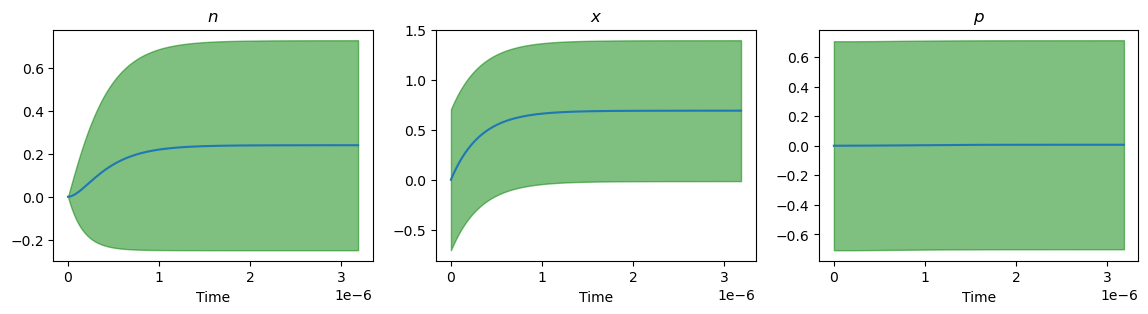

In [217]:
# psi_0 = squeeze(N, 1) * basis(N, 0)
psi_0 = basis(N, 0)

result = mesolve(H, psi_0, tlist, c_ops = c_op_list)

plot_expect_with_variance(N, [n, x, p], [r"$n$", r"$x$", r"$p$"],
                          result.states);

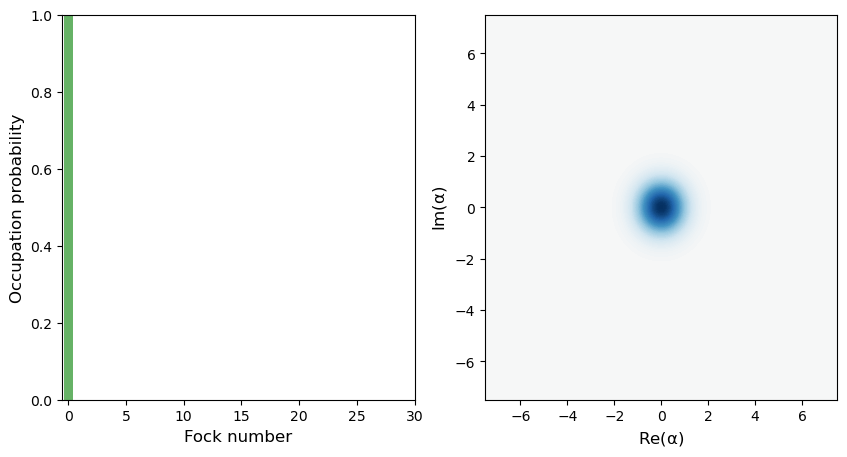

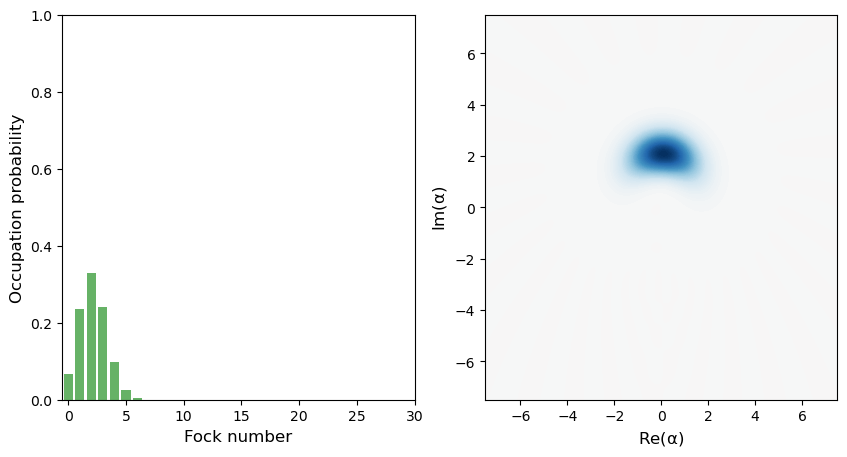

In [112]:
i = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].cla()
plot_fock_distribution(result.states[i], fig=fig, ax=axes[0])
plot_wigner(result.states[i], fig=fig, ax=axes[1])
plt.show()

i = -1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].cla()
plot_fock_distribution(result.states[i], fig=fig, ax=axes[0])
plot_wigner(result.states[i], fig=fig, ax=axes[1])
plt.show()

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" \
                src="data:video/x-m4v;base64,{0}">'.format(
        video_encoded
    )
    return HTML(video_tag)

def update(n):
    print(n)
    axes[0].cla()
    plot_fock_distribution(result.states[n], fig=fig, ax=axes[0])
    plot_wigner(result.states[n], fig=fig, ax=axes[1])
    return axes[0].artists + axes[1].artists


anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(result.states)),
                               blit=True)

anim.save("animation-coherent-state.mp4", fps=10, writer="ffmpeg")

plt.close(fig)

display_embedded_video("animation-coherent-state.mp4")

0
0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Sweep

The idea here is to replicate a VNA experiment with a weakly nonlinear mode. As you turn up the power, you may see a dip in the reflected power (output field amplitude). 

My theory is that the dip is due to a quantum effect, namely the spreading out of the wavefunction along the phase direction on the Wigner function plot. This is in contrast to other effects, such as classical noise scrambling the phase of the output.

Here we have to set up the sweep, as well as calculate the input-output relations. We assume input is a coherent state (this assumption does not affect the drive term, since the drive term assumes classical drive). To do this, I'll just use the mean of the x and p variables as the input fields. 

For large $\bar{n}$ with large phase uncertainty, we can track how much the phase scrambling is affecting the VNA power dip with the ratio $\frac{<\hat{x}>^2 + <\hat{p}>^2}{<\hat{n}>}$. 



In [380]:
from tqdm.notebook import tqdm

def sim_iteration(eps_1, kappa, w_1, alpha):
    
    pi = np.pi
    N = 30
    
    a = destroy(N)
    n = num(N)
    x = (a + a.dag()) / np.sqrt(2)
    p = -1j * (a - a.dag()) / np.sqrt(2)

    tlist = np.arange(0, np.round(30/kappa,9), 10e-9) # automatically adjust to reach steady-state

    H0 = alpha*(a.dag()*a.dag()*a*a) # dynamics are solved in the rotating frame

    H1_1 = a.dag()

    H1_2 = a

    #blais 2021 convention
    H = [[H0, tlist*0 + 1],[H1_1,eps_1*np.exp(-1j*w_1*tlist)],[H1_2,np.conj(eps_1)*np.exp(1j*w_1*tlist)]]

    c_op_list = []

    rate = kappa
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a)
        
    psi_0 = basis(N, 0)

    result = mesolve(H, psi_0, tlist, c_ops = c_op_list)
    
    return tlist, result

alpha = -1e6*2*np.pi
kappa = 5e6 * 2  *pi

input_power_dBms = np.linspace(-160, -120, 9)
w_1s = np.linspace(-kappa*4, kappa*4, 101)


expect_ns = np.zeros([len(input_power_dBms), len(w_1s)])
variance_ns = np.zeros([len(input_power_dBms), len(w_1s)])
expect_xs = np.zeros([len(input_power_dBms), len(w_1s)])
variance_xs = np.zeros([len(input_power_dBms), len(w_1s)])
expect_ps = np.zeros([len(input_power_dBms), len(w_1s)])
variance_ps = np.zeros([len(input_power_dBms), len(w_1s)])
expect_as = np.zeros([len(input_power_dBms), len(w_1s)], dtype=np.complex128)

output_powers = np.zeros([len(input_power_dBms), len(w_1s)]) #calculating input-output theory
output_phase = np.zeros([len(input_power_dBms), len(w_1s)])

for i in tqdm(range(0, len(input_power_dBms))):
    for j in tqdm(range(0, len(w_1s))):
        
        input_power_dBm = input_power_dBms[i]
        power = 1e-3 * 10 ** (input_power_dBm/10)
        hbar = 6.62e-34/(2*pi)
        w_a = 4.0e9*2*pi # just for the nbar calculation (bc solved in rotating frame)
        
        amplR = np.sqrt(power / (hbar*w_a))

        steady_state_nbar = 4*amplR**2/kappa
        
        eps_1 = 1j*np.sqrt(kappa)*amplR

        w_1 = w_1s[j]

        tlist, result = sim_iteration(eps_1, kappa, w_1, alpha)
        
        expect_n = expect(n, result.states[-1])
        variance_n = variance(n, result.states[-1])

        expect_x = expect(x, result.states[-1])
        variance_x = variance(x, result.states[-1])

        expect_p = expect(p, result.states[-1])
        variance_p = variance(p, result.states[-1])
        
        expect_a = expect(a, result.states[-1])
        
        expect_ns[i,j] = expect_n
        variance_ns[i,j] = variance_n
        expect_xs[i,j] = expect_x
        variance_xs[i,j] = variance_x
        expect_ps[i,j] = expect_p
        variance_ps[i,j] = variance_p
        expect_as[i,j] = expect_a
        
        ain_final = amplR*np.exp(-1j*w_1*tlist[-1])
        
        aout_final = (ain_final - np.sqrt(kappa)*expect_a)*np.exp(1j*w_1*tlist[-1])
        
        output_powers[i,j] = np.abs(aout_final)**2*(hbar*w_a)
        output_phase[i,j] = np.angle(aout_final)
        
        
        
        

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

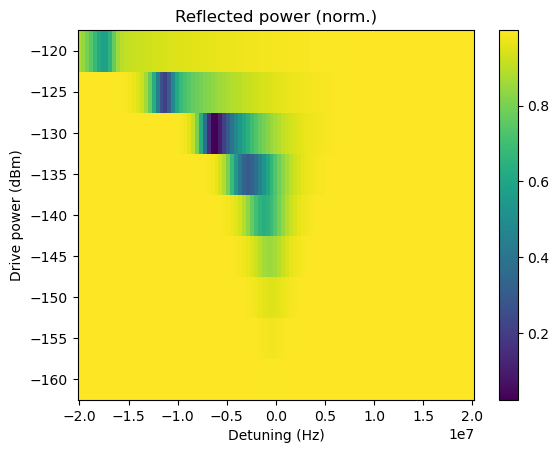

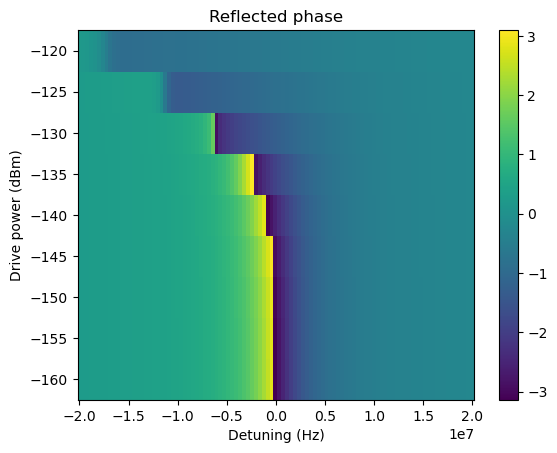

In [381]:
plt.pcolor(w_1s/(2*np.pi), input_power_dBms, (output_powers.transpose()/(1e-3 * 10 ** (input_power_dBms/10))).transpose())
plt.xlabel('Detuning (Hz)')
plt.ylabel('Drive power (dBm)')
plt.title('Reflected power (norm.)')
plt.colorbar()
plt.show()

plt.pcolor(w_1s/(2*np.pi),  input_power_dBms, output_phase)
plt.xlabel('Detuning (Hz)')
plt.ylabel('Drive power (dBm)')
plt.title('Reflected phase')
plt.colorbar()
plt.show()

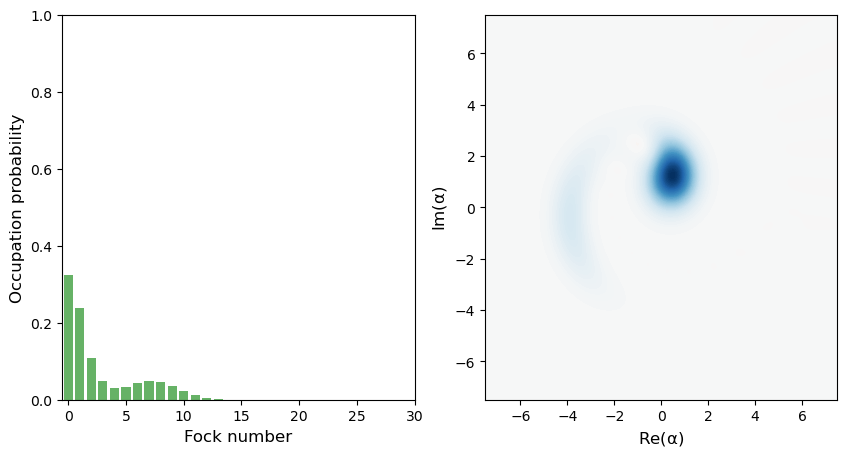

(-0.38490206363716223+0.6392876920456712j)

In [392]:
w_1 = -12e6 * 2 * pi
input_power_dBm = -125

power = 1e-3 * 10 ** (input_power_dBm/10)
hbar = 6.62e-34/(2*pi)
w_a = 4.0e9*2*pi # just for the nbar calculation (bc solved in rotating frame)
amplR = np.sqrt(power / (hbar*w_a))
steady_state_nbar = 4*amplR**2/kappa
eps_1 = 1j*np.sqrt(kappa)*amplR

tlist, result = sim_iteration(eps_1, kappa, w_1, alpha)

i=-1
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].cla()
plot_fock_distribution(result.states[i], fig=fig, ax=axes[0])
plot_wigner(result.states[i], fig=fig, ax=axes[1])
plt.show()

expect(a, result.states[i])

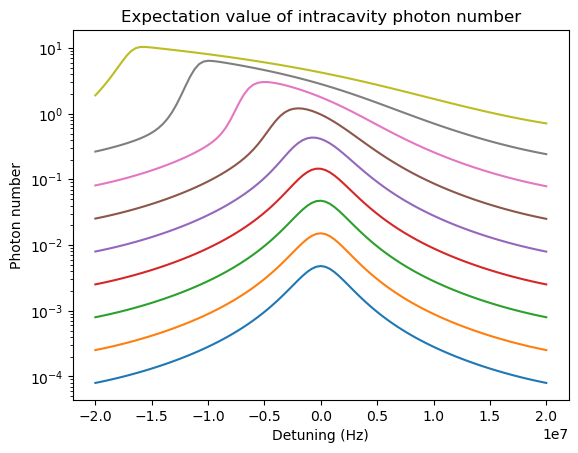

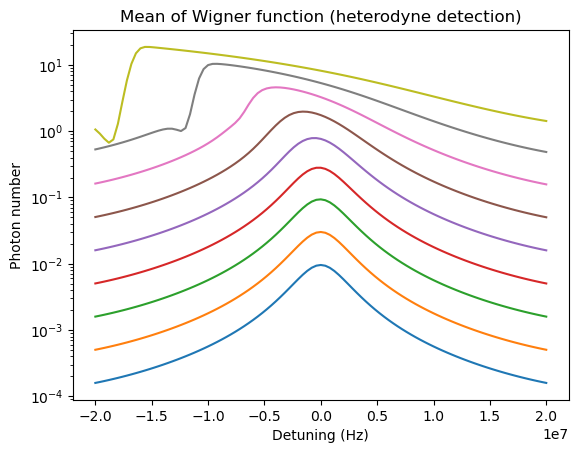

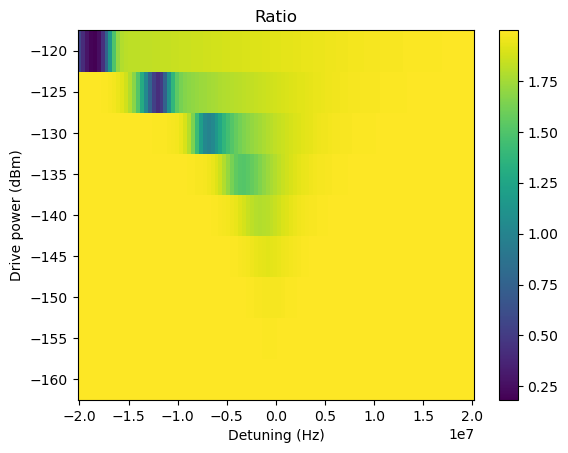

In [407]:
expect_power = expect_ps**2 + expect_xs**2

plt.semilogy(w_1s/(2*np.pi), expect_ns.transpose())
plt.xlabel('Detuning (Hz)')
plt.ylabel('Photon number')
plt.title('Expectation value of intracavity photon number')
plt.show()

plt.semilogy(w_1s/(2*np.pi), expect_power.transpose())
plt.xlabel('Detuning (Hz)')
plt.ylabel('Photon number')
plt.title('Mean of Wigner function (heterodyne detection)')
plt.show()

plt.pcolor(w_1s/(2*np.pi), input_power_dBms, expect_power/expect_ns)
plt.xlabel('Detuning (Hz)')
plt.ylabel('Drive power (dBm)')
plt.title('Ratio')
plt.colorbar()
plt.show()

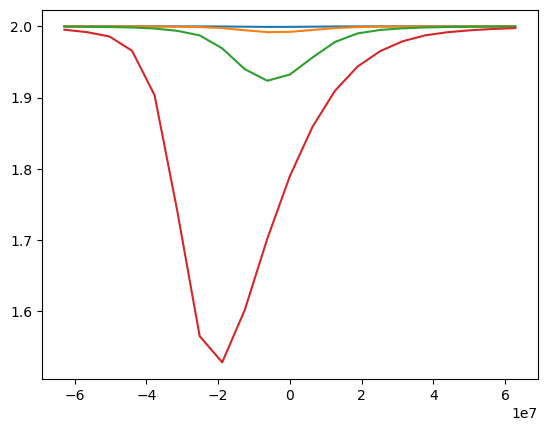

In [240]:
plt.plot(w_1s, expect_ns.transpose()/expect_ns.transpose())
plt.show()

In [249]:
coherent(5,1j)

Quantum object: dims=[[5], [1]], shape=(5, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.60655682+0.j        ]
 [ 0.        +0.60628133j]
 [-0.4303874 +0.j        ]
 [ 0.        -0.24104351j]
 [ 0.14552147+0.j        ]]

In [301]:
expect(a, coherent(30,2))

(1.9999999999999962+0j)